In [1]:
###fnc definitions, import data
import jax
import jax.numpy as jnp
from jax import jit
import jax.random as rnd
# from jax.experimental.host_callback import id_print
# from jax.experimental.host_callback import call
import optax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
# matplotlib.use('Agg')
from drawnow import drawnow
import numpy as np
import csv
import pickle
from pathlib import Path
from datetime import datetime
import re
import os
import sys
# from os.path import dirname, abspath
import scipy

def load_(str_):
    path_ = os.path.dirname(os.getcwd()) + '/pkl/' # Path(__file__).resolve().parents[1]
    with open(path_+str_,'rb') as file_:
        # param = pickle.load(file_)
        param_ = jnp.load(file_,allow_pickle=True)
    return param_

def geod_dist(dots,pos):### calculate geodesic
    pos_ = pos #(pos+jnp.pi)%(2*jnp.pi)-jnp.pi # could cause problems...
    th1 = jnp.minimum(jnp.abs(pos_[1]-dots[:,1]),2*jnp.pi-jnp.abs(pos_[1]-dots[:,1]))
    th2 = jnp.minimum(jnp.abs(pos_[0]-dots[:,0]),2*jnp.pi-jnp.abs(pos_[0]-dots[:,0]))
    return jnp.sqrt(th1**2+th2**2)

def geod_dist_dot(dot,pos):### calculate geodesic for single dot
    th1 = jnp.minimum(jnp.abs(pos[1]-dot[1]),2*jnp.pi-jnp.abs(pos[1]-dot[1]))
    th2 = jnp.minimum(jnp.abs(pos[0]-dot[0]),2*jnp.pi-jnp.abs(pos[0]-dot[0]))
    return jnp.sqrt(th1**2+th2**2)

geod_dist_dot_vmap = jax.vmap(geod_dist_dot,in_axes=(None,0),out_axes=0)

vals_train,vals_test,theta_test = load_('v9_all_25_04-1610.pkl')
(R_tot,R_obj,R_env,R_dot,R_sel),(sd_tot,sd_obj,sd_env,sd_dot,sd_sel) = vals_train
(pos_arr,switch_arr,R_all) = vals_test
(R_test,R_r,R_g,R_b) = R_all # [TESTS,VMAPS,IT+1]

ki = rnd.split(rnd.PRNGKey(0),num=30)

print(R_tot.shape)

(2000,)


/tmp/ipykernel_8308/426846522.py:12: RuntimeWarning: invalid value encountered in multiply
  intervals = np.nan*np.empty((TESTS,VMAPS,IT//2))


[6817 6640 6324 5586 4426 3102 1869  962  420  158   58   21    8    6
    4    2    1]


/tmp/ipykernel_8308/426846522.py:40: RuntimeWarning: Mean of empty slice
  avg_intervals = np.nanmean(intervals,axis=(0,1))
/homes/lrj34/projects/meta_rl_ego_sim/venv2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


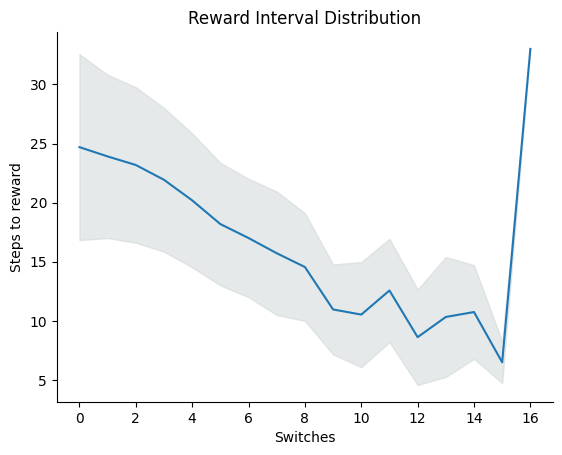

In [17]:
#find reward intervals
TESTS = R_test.shape[0]
VMAPS = R_test.shape[1]
IT = R_test.shape[2]
threshold = 0.6

# get dots

# get selected dot
# find geod_dist to dot

intervals = np.nan*np.empty((TESTS,VMAPS,IT//2))
# counts = np.nan*np.empty((IT//2))
sel_dot = np.nan*np.empty((TESTS,VMAPS,2))
dis_ = np.nan*np.empty((TESTS,VMAPS,IT//2))
# pos_locs = np.nan*np.empty((TESTS,VMAPS,IT//2,2))
for t in range(TESTS):
    for v in range(VMAPS):
        # dots = theta_test["ENV"]["DOTS"][t,:,:,v] # [3,2]
        # sel = theta_test["ENV"]["SELECT"][t,v,:] # [3]
        # sel_dot = np.dot(sel,dots) # [t,v,:], [2]
        # dis_0[t,v] = geod_dist_(sel_dot[t,v,:],[0,0]) #np.norm
        # find locations of agent after switching
        switch_locs = np.where(switch_arr[t,v,:]==1)
        pos_locs = pos_arr[t,v,[0,switch_locs],:] # switch + initial loc (ignore last)
        dis_[t,v,pos_locs.size[0]-1] = geod_dist_dot_vmap(sel_dot,pos_locs[:-1]) # [pos_locs,] new distance to rewarded dot at each teleport
        # compare dis_[t,v,:] (distance to dot after teleport) to intervals[t,v,:] (steps to reward after teleport)
        
        obj_peaks = scipy.signal.find_peaks((-R_test[t,v,:]),height=threshold)
        if obj_peaks[0].size == 0:
            continue
        else:
            intervals[t,v,:len(obj_peaks[0])-1] = np.diff(obj_peaks[0])
        # if v%100 == 0:
            # print(v)
            # print(obj_peaks[0].size)

        r_peaks = scipy.signal.find_peaks((-R_r[t,v,:]),height=threshold)
        g_peaks = scipy.signal.find_peaks((-R_g[t,v,:]),height=threshold)
        b_peaks = scipy.signal.find_peaks((-R_b[t,v,:]),height=threshold)

# intervals = np.where(np.isfinite(intervals), intervals, 0)
counts = np.count_nonzero(~np.isnan(intervals),axis=(0,1))
counts = counts[np.nonzero(counts)]
print(counts)
# find nonzero elements of 'counts':
avg_intervals = np.nanmean(intervals,axis=(0,1))
avg_intervals = avg_intervals[~np.isnan(avg_intervals)]
# print(avg_intervals)
sd_intervals = np.nanstd(intervals,axis=(0,1))
sd_intervals = sd_intervals[~np.isnan(sd_intervals)]
# print(sd_intervals)
int_hist = np.histogram(avg_intervals)

#plot
fig,ax = plt.subplots()
ax.plot(np.arange(len(avg_intervals)),avg_intervals)
ax.fill_between(np.arange(len(avg_intervals)),avg_intervals-sd_intervals/2,avg_intervals+sd_intervals/2,alpha=0.5,color='#cdd4d4')
# ax.errorbar(np.arange(len(avg_intervals)),avg_intervals,yerr=sd_intervals/2,c='k')
# ax.hist(avg_intervals,bins=20)
ax.set_xlabel('Switches')
ax.set_ylabel('Steps to reward')
ax.set_title('Reward Interval Distribution')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

path__ = os.path.dirname(os.getcwd()) + '/figs_analysis/'
dt = datetime.now().strftime("%d_%m-%H%M")
plt.savefig(path__ + 'reward_intervals_' + dt + '.png')
# plt.show()

In [13]:
print(counts)

[6817 6640 6324 5586 4426 3102 1869  962  420  158   58   21    8    6
    4    2    1    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [ ]:
#(replot training)
plt.figure()
# title__ = f'v9 training, tot epochs={TOT_EPOCHS}, it={IT}, vmaps={VMAPS}, init={INIT:.2f}, update={UPDATE:.5f}, SIGMA_A={SIGMA_A:.1f}, SIGMA_R0={SIGMA_R0:.1f}, SIGMA_RINF={SIGMA_RINF:.1f}, \n SIGMA_N={SIGMA_N:.1f}, STEP={STEP:.3f} WD={WD:.5f}, LAMBDA_D={LAMBDA_D:.4f}, LAMBDA_E={LAMBDA_E:.4f}, LAMBDA_S={LAMBDA_S:.4f}, NEURONS={NEURONS}' # \n colors={jnp.array_str(COLORS[0][:]) + jnp.array_str(COLORS[1][:]) + jnp.array_str(COLORS[2][:])}' #  + jnp.array_str(COLORS[3][:]) + jnp.array_str(COLORS[4][:])}'
fig,ax = plt.subplots(2,3,figsize=(16,9))
# plt.suptitle(title__,fontsize=14)
plt.subplot(2,3,1)
plt.errorbar(jnp.arange(len(R_tot)),R_tot,yerr=sd_tot/2,ecolor="black",elinewidth=0.5,capsize=1.5)
plt.ylabel(r'$R_{tot}$',fontsize=15)
plt.xlabel(r'Iteration',fontsize=12)
plt.subplot(2,3,2)
plt.errorbar(jnp.arange(len(R_obj)),R_obj,yerr=sd_obj/2,ecolor="black",elinewidth=0.5,capsize=1.5)
plt.ylabel(r'$R_{obj}$',fontsize=15)
plt.xlabel(r'Iteration',fontsize=12)
plt.subplot(2,3,3)
plt.errorbar(jnp.arange(len(R_env)),R_env,yerr=sd_env/2,ecolor="black",elinewidth=0.5,capsize=1.5)
plt.ylabel(r'$R_{env}$',fontsize=15)
plt.xlabel(r'Iteration',fontsize=12)
plt.subplot(2,3,4)
plt.errorbar(jnp.arange(len(R_dot)),R_dot,yerr=sd_dot/2,ecolor="black",elinewidth=0.5,capsize=1.5)
plt.ylabel(r'$R_{dot}$',fontsize=15)
plt.xlabel(r'Iteration',fontsize=12)
plt.subplot(2,3,5)
plt.errorbar(jnp.arange(len(R_sel)),R_sel,yerr=sd_sel/2,ecolor="black",elinewidth=0.5,capsize=1.5)
plt.ylabel(r'$R_{sel}$',fontsize=15)
plt.xlabel(r'Iteration',fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
#(replot testing)
geod_dist_vmap = jax.vmap(geod_dist,in_axes=(None,0),out_axes=0)# (e_t,pos_t)
colors_ = np.float32([[255,0,0],[0,255,0],[0,0,255]])/255 #theta_0["ENV"]["COLORS"]/255
colormap = cm.seismic(np.linspace(0,1,IT+1), alpha=1)

plt.figure()
# title__ = f'v9 testing, tot epochs={TOT_EPOCHS}, it={IT}, vmaps={VMAPS}, init={INIT:.2f}, update={UPDATE:.5f}, SIGMA_N={SIGMA_N}, SIGMA_A={SIGMA_A:.1f}, SIGMA_R0={SIGMA_R0:.1f}, SIGMA_RINF={SIGMA_RINF:.1f}, \n SIGMA_N={SIGMA_N:.1f}, STEP={STEP:.3f} WD={WD:.5f}, LAMBDA_D={LAMBDA_D:.4f}, LAMBDA_E={LAMBDA_E:.4f}, LAMBDA_S={LAMBDA_S:.4f}, NEURONS={NEURONS}'
fig,axis = plt.subplots(2*TESTS,4,figsize=(15,5*TESTS+2))#(4,5)
# plt.suptitle(title__,fontsize=14)
for i in range(TESTS):
    k = rnd.randint(ki[18+i],(),0,VMAPS) # rnd.choice(ki[18+j],loop_params["VMAPS"],replace=False)
    ax0 = plt.subplot2grid((2*TESTS,4),(2*i,2),colspan=2)
    ax0.set_ylabel(r'$dis$',fontsize=16)
    # dis_old = dis_arr[i,k,:,:] # [TESTS,VMAPS,IT,3]
    ax0.tick_params(axis='both', which='major', labelsize=14)
    ax0.set_ylim(-0.2,jnp.pi+0.2) # 2*jnp.pi*jnp.sqrt(2)

    ax1 = plt.subplot2grid((2*TESTS,4),(2*i,0),rowspan=2,colspan=2)
    pos_ = pos_arr[i,k,:,:] # [TESTS,VMAPS,IT,2]
    ax1.scatter(pos_[:,0],pos_[:,1],s=30,color=colormap,marker='.')# axis[i,1]

    sel_ = theta_test["ENV"]["SELECT"][i,k,:] # [EPOCHS,VMAPS,3]
    dots_ = theta_test["ENV"]["DOTS"][i,:,:,k] # [EPOCHS,3,2,VMAPS]
    dis_ = geod_dist_vmap(dots_,pos_)
    ax2 = plt.subplot2grid((2*TESTS,4),(2*i+1,2),colspan=2)
    ax2.plot(R_test[i,k,1:],color='k',linewidth=2) #axis[i,2]
    ax2.set_ylabel(r'$R_{tot}$',fontsize=16)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax2.set_ylim(-1.1,0.1) # -1.1,0 -jnp.sqrt(2*jnp.pi)*
    for j in range(theta_test["ENV"]["N_DOTS"]):
        ax0.plot(dis_[1:,j],color=(colors_[j,:]),linewidth=3)#axis[i,0], tuple
        ax0.plot(dis_[1:,j],color=(colors_[j,:]),alpha=0.5,linewidth=1)
        ax1.scatter(dots_[j,0],dots_[j,1],s=60,marker='x',color=(colors_[j,:]))

    ax1.set_xlim(-jnp.pi,jnp.pi)
    ax1.set_ylim(-jnp.pi,jnp.pi)
    ax1.set_xticks([-jnp.pi,-jnp.pi/2,0,jnp.pi/2,jnp.pi])
    ax1.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$'],fontsize=14)
    ax1.set_yticks([-jnp.pi,-jnp.pi/2,0,jnp.pi/2,jnp.pi])
    ax1.set_yticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$'],fontsize=14)
    ax1.set_aspect('equal')
    ax1.set_title(f'sel={sel_}',fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94) 